In [19]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from matplotlib import patheffects as pe
from statsmodels.tools.tools import add_constant
import seaborn as sns
import math

In [21]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from sklearn.linear_model import LinearRegression
from statsmodels.formula.api import ols
from sklearn.metrics import r2_score

In [2]:
df = pd.read_csv('FINAL_data.csv')

In [3]:
y_log = np.log(df['price'])
X_train = df.drop('price', axis = 1)

In [4]:
target_quantiles = [0.25, 0.5, 0.75]

quantile_models = {}

for quantile in target_quantiles:
    qr_model = sm.QuantReg(y_log, X_train)
    fitted_model = qr_model.fit(q=quantile, max_iter=1e6)
    quantile_models[quantile] = fitted_model

model_summaries = {
    quantile: quantile_models[quantile].summary()
    for quantile in target_quantiles}

/usr/local/lib/python3.11/dist-packages/statsmodels/regression/linear_model.py:1966: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(eigvals[0]/eigvals[-1])
/usr/local/lib/python3.11/dist-packages/statsmodels/regression/linear_model.py:1966: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(eigvals[0]/eigvals[-1])
/usr/local/lib/python3.11/dist-packages/statsmodels/regression/linear_model.py:1966: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(eigvals[0]/eigvals[-1])


In [5]:
model_summaries

{0.25: <class 'statsmodels.iolib.summary.Summary'>
 """
                          QuantReg Regression Results                          
 Dep. Variable:                  price   Pseudo R-squared:               0.2788
 Model:                       QuantReg   Bandwidth:                     0.07114
 Method:                 Least Squares   Sparsity:                       0.5326
 Date:                Tue, 22 Apr 2025   No. Observations:                 1326
 Time:                        16:36:49   Df Residuals:                     1303
                                         Df Model:                           22
                                                          coef    std err          t      P>|t|      [0.025      0.975]
 ----------------------------------------------------------------------------------------------------------------------
 metro_time                                            -0.0025      0.001     -1.775      0.076      -0.005       0.000
 info_total_area        

In [6]:
import plotly.graph_objects as go


q25 = y_log.quantile(0.25)
q50 = y_log.quantile(0.50)
q75 = y_log.quantile(0.75)

hist_data = go.Histogram(
    x=y_log,
    histnorm='probability',
    nbinsx=50,
    name='Log Price Distribution',
    opacity=0.75,
    marker=dict(color='lightblue', line=dict(color='black', width=1))
)

quantile_lines = [
    go.Scatter(
        x=[q25, q25],
        y=[0, 0.3],
        mode='lines',
        name='25th Quantile',
        line=dict(color='red', dash='dot')
    ),
    go.Scatter(
        x=[q50, q50],
        y=[0, 0.3],
        mode='lines',
        name='50th Quantile',
        line=dict(color='red', dash='dash')
    ),
    go.Scatter(
        x=[q75, q75],
        y=[0, 0.3],
        mode='lines',
        name='75th Quantile',
        line=dict(color='red', dash='solid')
    )
]


layout = go.Layout(
    title='Log Price Distribution with Quantiles',
    xaxis=dict(title='Log Price'),
    yaxis=dict(title='Probability'),
    barmode='overlay',
    showlegend=True
)


fig = go.Figure(data=[hist_data] + quantile_lines, layout=layout)
fig.show()


In [7]:
price_percentiles = df['price'].quantile(q=[0.25, 0.5, 0.75])

price_bins = [df['price'].min()]
price_bins.extend(price_percentiles.to_list())
price_bins.append(df['price'].max() + 0.01)

category_labels = [
    f"До {int(100*q)}-го перцентиля"
    for q in [0.25, 0.5, 0.75]
] + ["Максимальная цена"]

df['Price Quantile Category'] = pd.cut(
    df['price'],
    bins=price_bins,
    labels=category_labels,
    include_lowest=True
)

price_groups = df.groupby('Price Quantile Category')['price'] \
                .apply(lambda x: x.tolist())

<ipython-input-7-cdd9fa026afe>:19: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



In [8]:
price_groups

,price
Price Quantile Category,
До 25-го перцентиля,"[30000, 29000, 35000, 34000, 25000, 25000, 299..."
До 50-го перцентиля,"[59900, 60000, 60000, 60000, 60000, 55000, 600..."
До 75-го перцентиля,"[68000, 65000, 65000, 61000, 65000, 65000, 650..."
Максимальная цена,"[470000, 270000, 75000, 550000, 90000, 295000,..."


In [9]:
five_per = []
for i in price_groups:
  five_per.append(np.exp(i))

<ipython-input-9-67bab09df113>:3: RuntimeWarning:

overflow encountered in exp



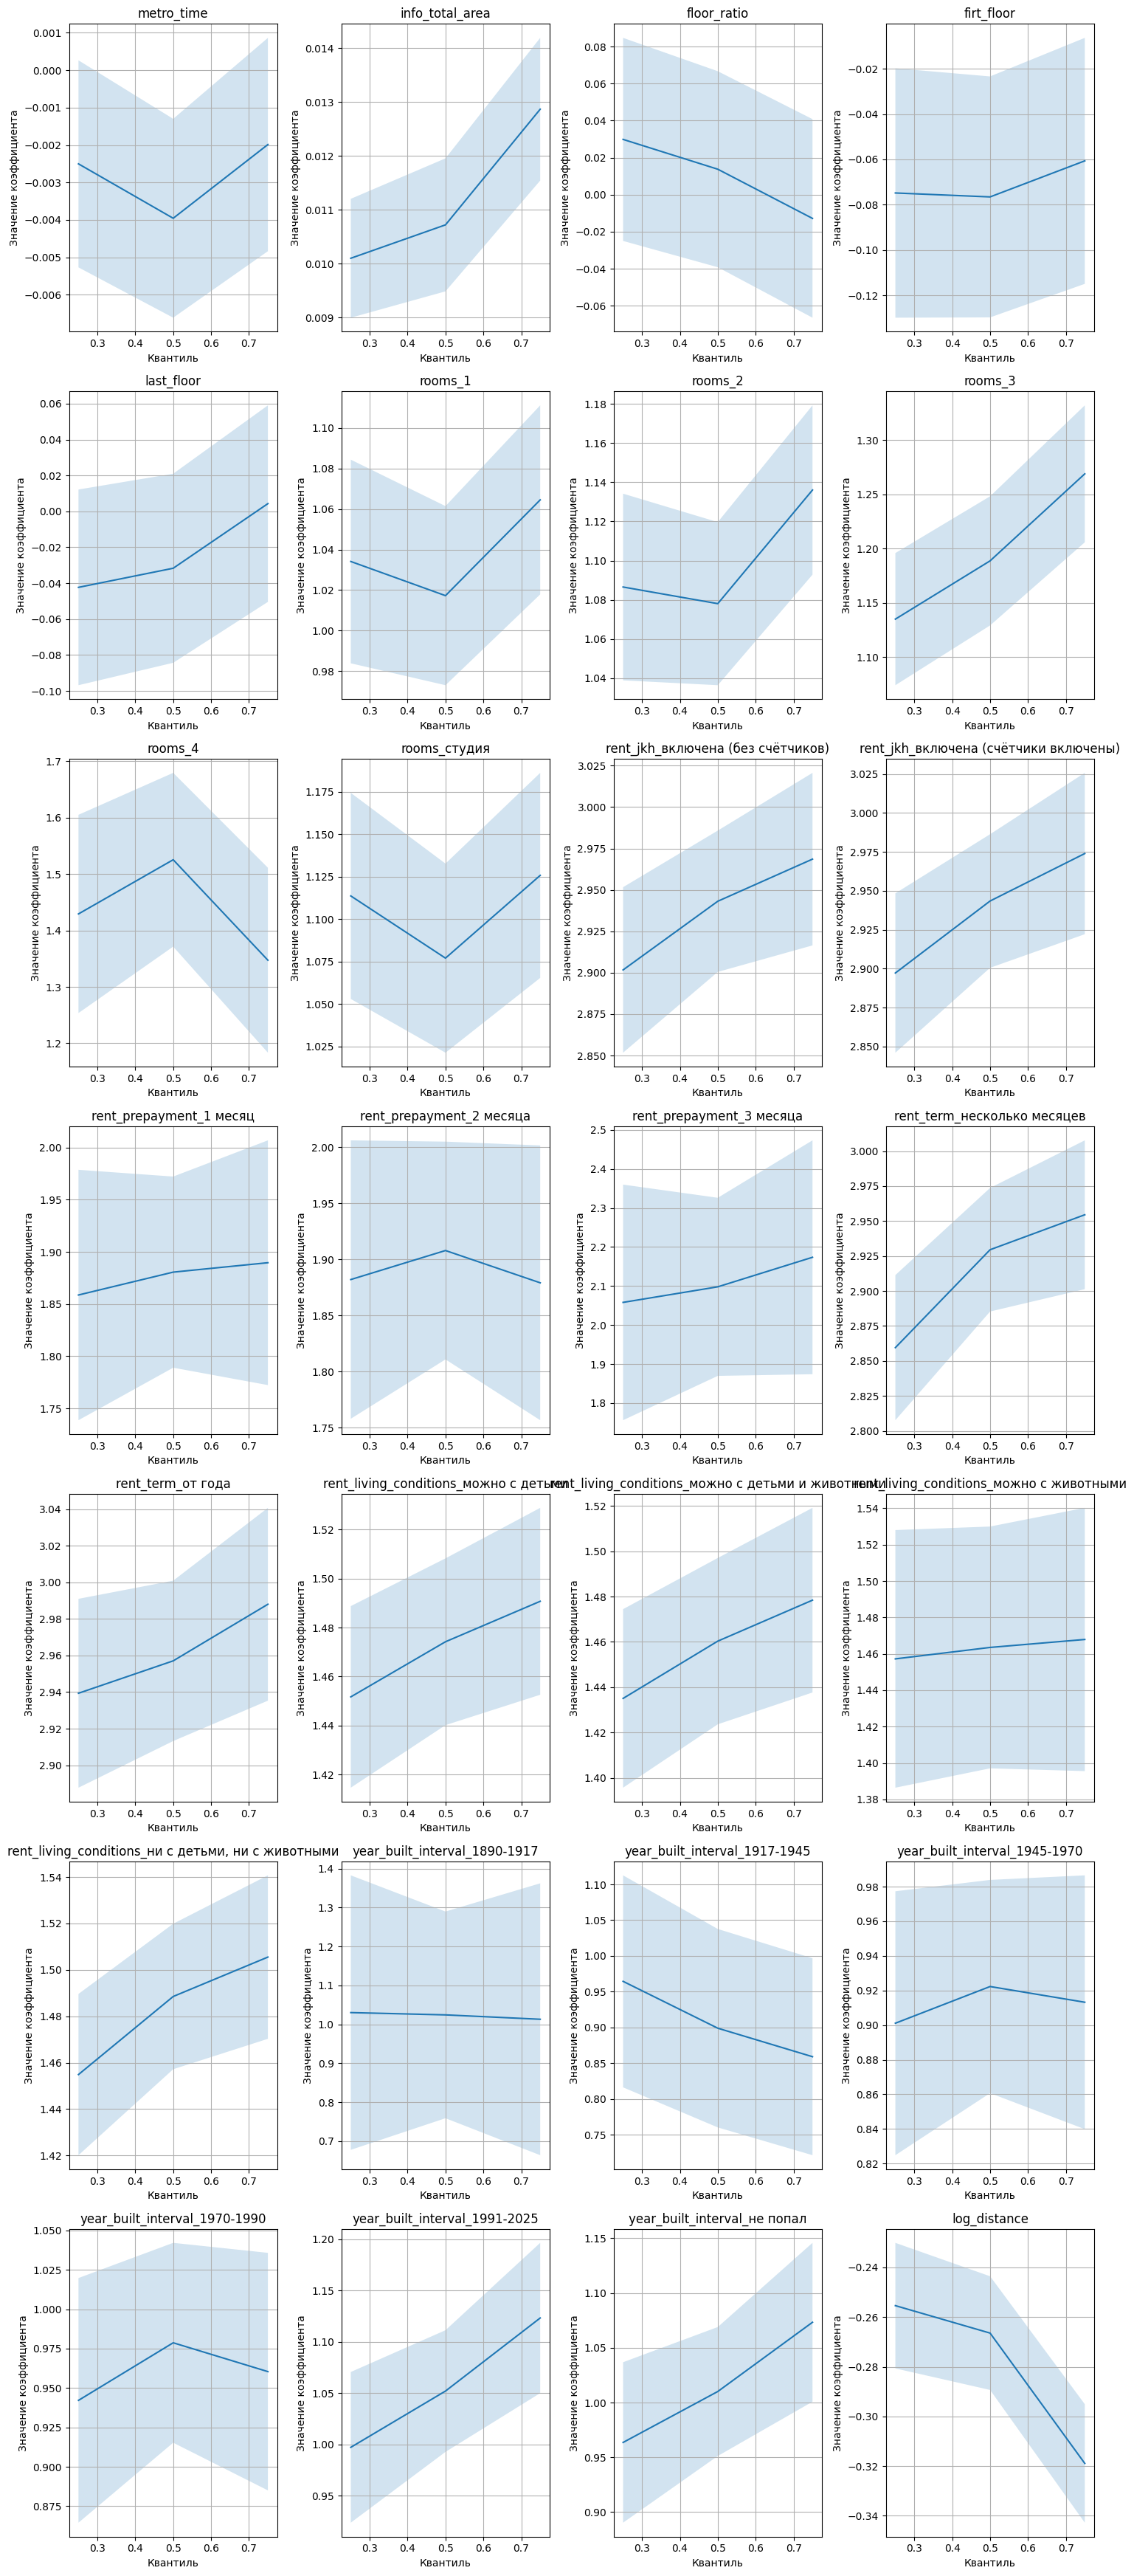

In [10]:
analysis_quantiles = [0.25, 0.5, 0.75]

quantile_model_results = {}
for quantile in analysis_quantiles:
    qr_model = sm.QuantReg(y_log, X_train)
    fitted_model = qr_model.fit(q=quantile, max_iter=1e6)
    quantile_model_results[quantile] = fitted_model

coefficients_matrix = pd.DataFrame(index=X_train.columns, columns=analysis_quantiles)

for quantile in analysis_quantiles:
    for feature in X_train.columns:
        coefficients_matrix.loc[feature, quantile] = quantile_model_results[quantile].params[feature]

confidence_intervals = {feature: [] for feature in X_train.columns}

for quantile in analysis_quantiles:
    conf_int = quantile_model_results[quantile].conf_int()
    for feature in X_train.columns:
        feature_idx = X_train.columns.get_loc(feature)
        confidence_intervals[feature].append(
            (quantile, conf_int.iloc[feature_idx, 0], conf_int.iloc[feature_idx, 1])
        )

plot_data = []

for feature in X_train.columns:
    for quantile in analysis_quantiles:
        quantile_index = analysis_quantiles.index(quantile)
        plot_data.append({
            'quantile': quantile,
            'feature': feature,
            'coefficient': coefficients_matrix.loc[feature, quantile],
            'lower': confidence_intervals[feature][quantile_index][1],
            'upper': confidence_intervals[feature][quantile_index][2]
        })

plot_df = pd.DataFrame(plot_data)

n_features = len(X_train.columns)
n_rows = 7
n_cols = 4

assert n_features <= n_rows * n_cols, "Too many features to fit in a 7x4 grid."

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))

axes = axes.flatten()

for idx, feature in enumerate(X_train.columns):
    ax = axes[idx]

    feature_data = plot_df[plot_df['feature'] == feature]

    sns.lineplot(data=feature_data, x='quantile', y='coefficient', hue='feature', markers=True, dashes=False, ax=ax, legend=False)

    ax.fill_between(feature_data['quantile'], feature_data['lower'], feature_data['upper'], alpha=0.2)

    ax.set_title(f'{feature}')
    ax.set_xlabel('Квантиль')
    ax.set_ylabel('Значение коэффициента')
    ax.grid(True)

plt.tight_layout()
plt.show()

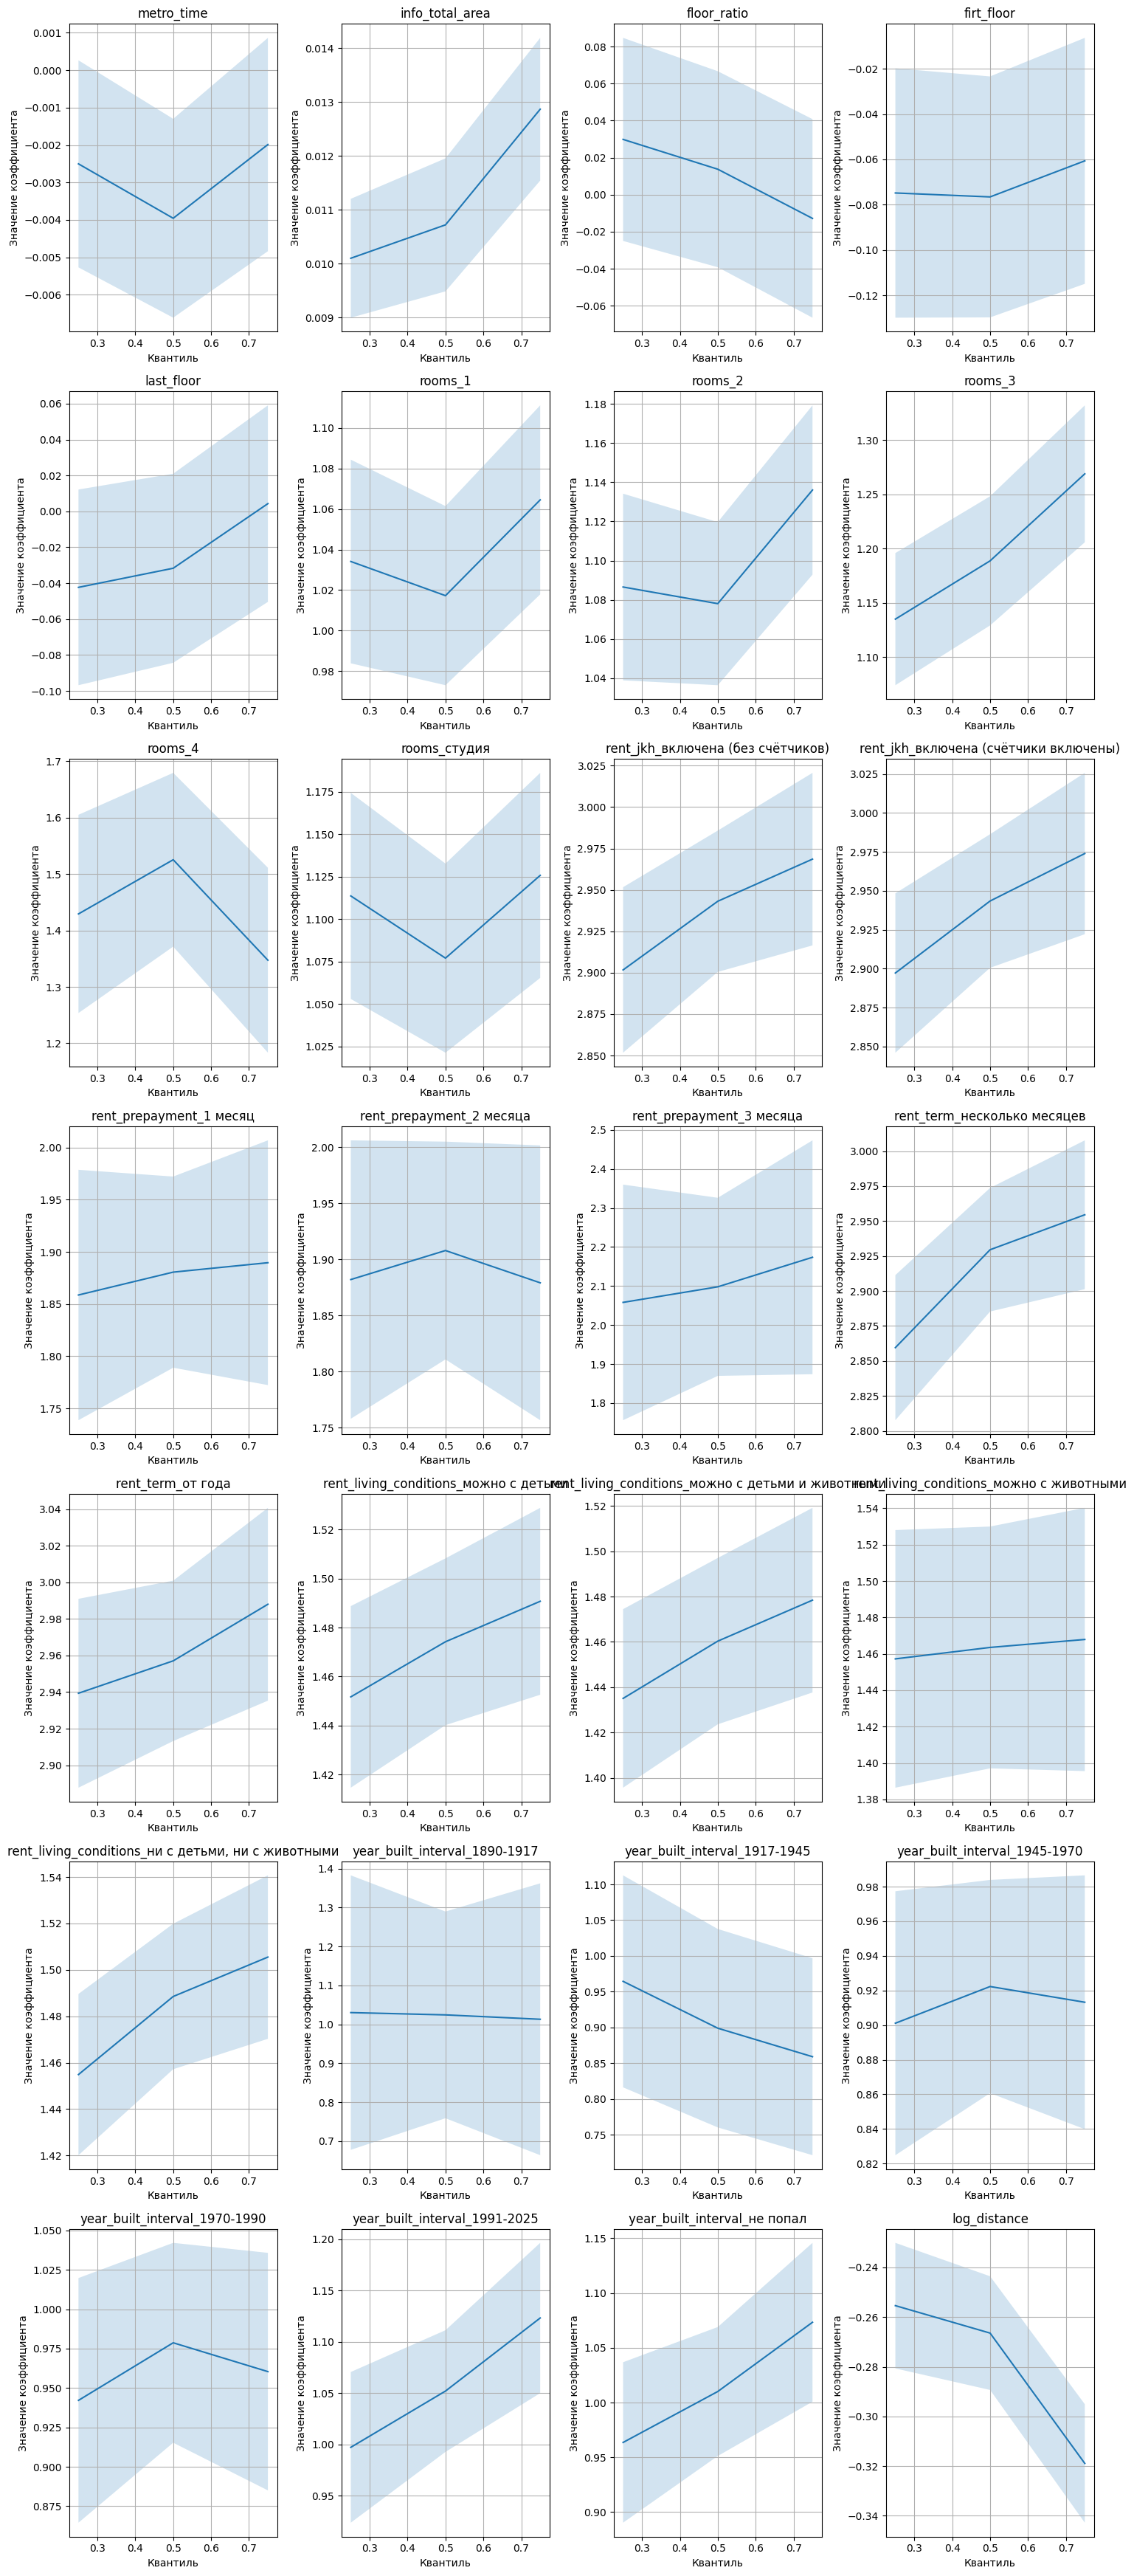

In [11]:
analysis_quantiles = [0.25, 0.5, 0.75]

quantile_model_results = {}
for quantile in analysis_quantiles:
    qr_model = sm.QuantReg(y_log, X_train)
    fitted_model = qr_model.fit(q=quantile, max_iter=1e6)
    quantile_model_results[quantile] = fitted_model

coefficients_matrix = pd.DataFrame(index=X_train.columns, columns=analysis_quantiles)

for quantile in analysis_quantiles:
    for feature in X_train.columns:
        coefficients_matrix.loc[feature, quantile] = quantile_model_results[quantile].params[feature]

confidence_intervals = {feature: [] for feature in X_train.columns}

for quantile in analysis_quantiles:
    conf_int = quantile_model_results[quantile].conf_int()
    for feature in X_train.columns:
        feature_idx = X_train.columns.get_loc(feature)
        confidence_intervals[feature].append(
            (quantile, conf_int.iloc[feature_idx, 0], conf_int.iloc[feature_idx, 1])
        )

plot_data = []

for feature in X_train.columns:
    for quantile in analysis_quantiles:
        quantile_index = analysis_quantiles.index(quantile)
        plot_data.append({
            'quantile': quantile,
            'feature': feature,
            'coefficient': coefficients_matrix.loc[feature, quantile],
            'lower': confidence_intervals[feature][quantile_index][1],
            'upper': confidence_intervals[feature][quantile_index][2]
        })

plot_df = pd.DataFrame(plot_data)

n_features = len(X_train.columns)
n_rows = 7
n_cols = 4

assert n_features <= n_rows * n_cols, "Too many features to fit in a 7x4 grid."

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))

axes = axes.flatten()

for idx, feature in enumerate(X_train.columns):
    ax = axes[idx]

    feature_data = plot_df[plot_df['feature'] == feature]

    sns.lineplot(data=feature_data, x='quantile', y='coefficient', hue='feature', markers=True, dashes=False, ax=ax, legend=False)

    ax.fill_between(feature_data['quantile'], feature_data['lower'], feature_data['upper'], alpha=0.2)

    lower_25 = plot_df[(plot_df['feature'] == feature) & (plot_df['quantile'] == 0.25)]
    upper_75 = plot_df[(plot_df['feature'] == feature) & (plot_df['quantile'] == 0.75)]

    overlap_lower = max(lower_25['upper'].values[0], upper_75['lower'].values[0])
    overlap_upper = min(upper_75['upper'].values[0], lower_25['lower'].values[0])

    if overlap_lower < overlap_upper:
        ax.fill_between([0.25, 0.75], overlap_lower, overlap_upper, color='red', alpha=0.3, linewidth=2, edgecolor='red')

    ax.set_title(f'{feature}')
    ax.set_xlabel('Квантиль')
    ax.set_ylabel('Значение коэффициента')
    ax.grid(True)

plt.tight_layout()
plt.show()

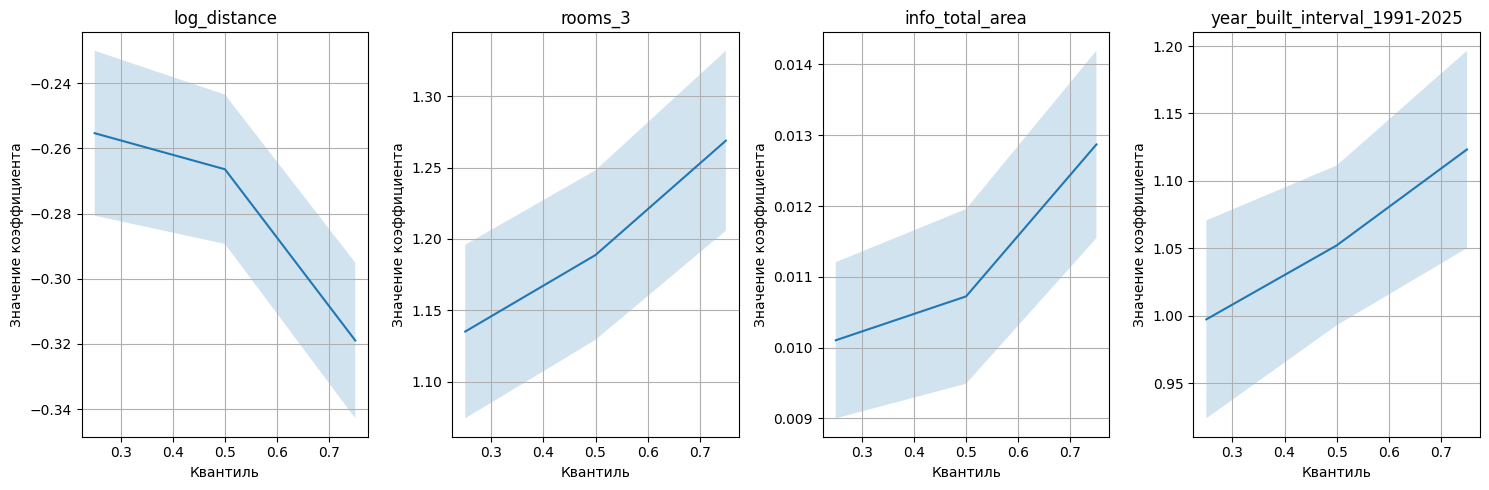

In [12]:
filtered_df = df[
    (df['year_built_interval_1991-2025'].notna()) &
    (df['log_distance'].notna()) &
    (df['rooms_3'].notna()) &
    (df['info_total_area'].notna())
]

y_log = np.log(filtered_df['price'])

analysis_quantiles = [0.25, 0.5, 0.75]

quantile_model_results = {}
for quantile in analysis_quantiles:
    qr_model = sm.QuantReg(y_log, X_train)
    fitted_model = qr_model.fit(q=quantile, max_iter=1e6)
    quantile_model_results[quantile] = fitted_model

coefficients_matrix = pd.DataFrame(index=X_train.columns, columns=analysis_quantiles)

for quantile in analysis_quantiles:
    for feature in X_train.columns:
        coefficients_matrix.loc[feature, quantile] = quantile_model_results[quantile].params[feature]

confidence_intervals = {feature: [] for feature in X_train.columns}

for quantile in analysis_quantiles:
    conf_int = quantile_model_results[quantile].conf_int()
    for feature in X_train.columns:
        feature_idx = X_train.columns.get_loc(feature)
        confidence_intervals[feature].append(
            (quantile, conf_int.iloc[feature_idx, 0], conf_int.iloc[feature_idx, 1])
        )

plot_data = []

for feature in X_train.columns:
    for quantile in analysis_quantiles:
        quantile_index = analysis_quantiles.index(quantile)
        plot_data.append({
            'quantile': quantile,
            'feature': feature,
            'coefficient': coefficients_matrix.loc[feature, quantile],
            'lower': confidence_intervals[feature][quantile_index][1],
            'upper': confidence_intervals[feature][quantile_index][2]
        })

feature_list = ['log_distance', 'rooms_3', 'info_total_area', 'year_built_interval_1991-2025']

n_features = len(feature_list)
n_rows = 1
n_cols = 4

assert n_features <= n_rows * n_cols, "Too many features to fit in a 7x4 grid."

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))

axes = axes.flatten()

for idx, feature in enumerate(feature_list):
    ax = axes[idx]

    feature_data = plot_df[plot_df['feature'] == feature]

    sns.lineplot(data=feature_data, x='quantile', y='coefficient', hue='feature', markers=True, dashes=False, ax=ax, legend=False)

    ax.fill_between(feature_data['quantile'], feature_data['lower'], feature_data['upper'], alpha=0.2)

    lower_25 = plot_df[(plot_df['feature'] == feature) & (plot_df['quantile'] == 0.25)]
    upper_75 = plot_df[(plot_df['feature'] == feature) & (plot_df['quantile'] == 0.75)]

    overlap_lower = max(lower_25['upper'].values[0], upper_75['lower'].values[0])
    overlap_upper = min(upper_75['upper'].values[0], lower_25['lower'].values[0])

    if overlap_lower < overlap_upper:
        ax.fill_between([0.25, 0.75], overlap_lower, overlap_upper, color='red', alpha=0.3, linewidth=2, edgecolor='red')

    ax.set_title(f'{feature}')
    ax.set_xlabel('Квантиль')
    ax.set_ylabel('Значение коэффициента')
    ax.grid(True)

plt.tight_layout()
plt.show()

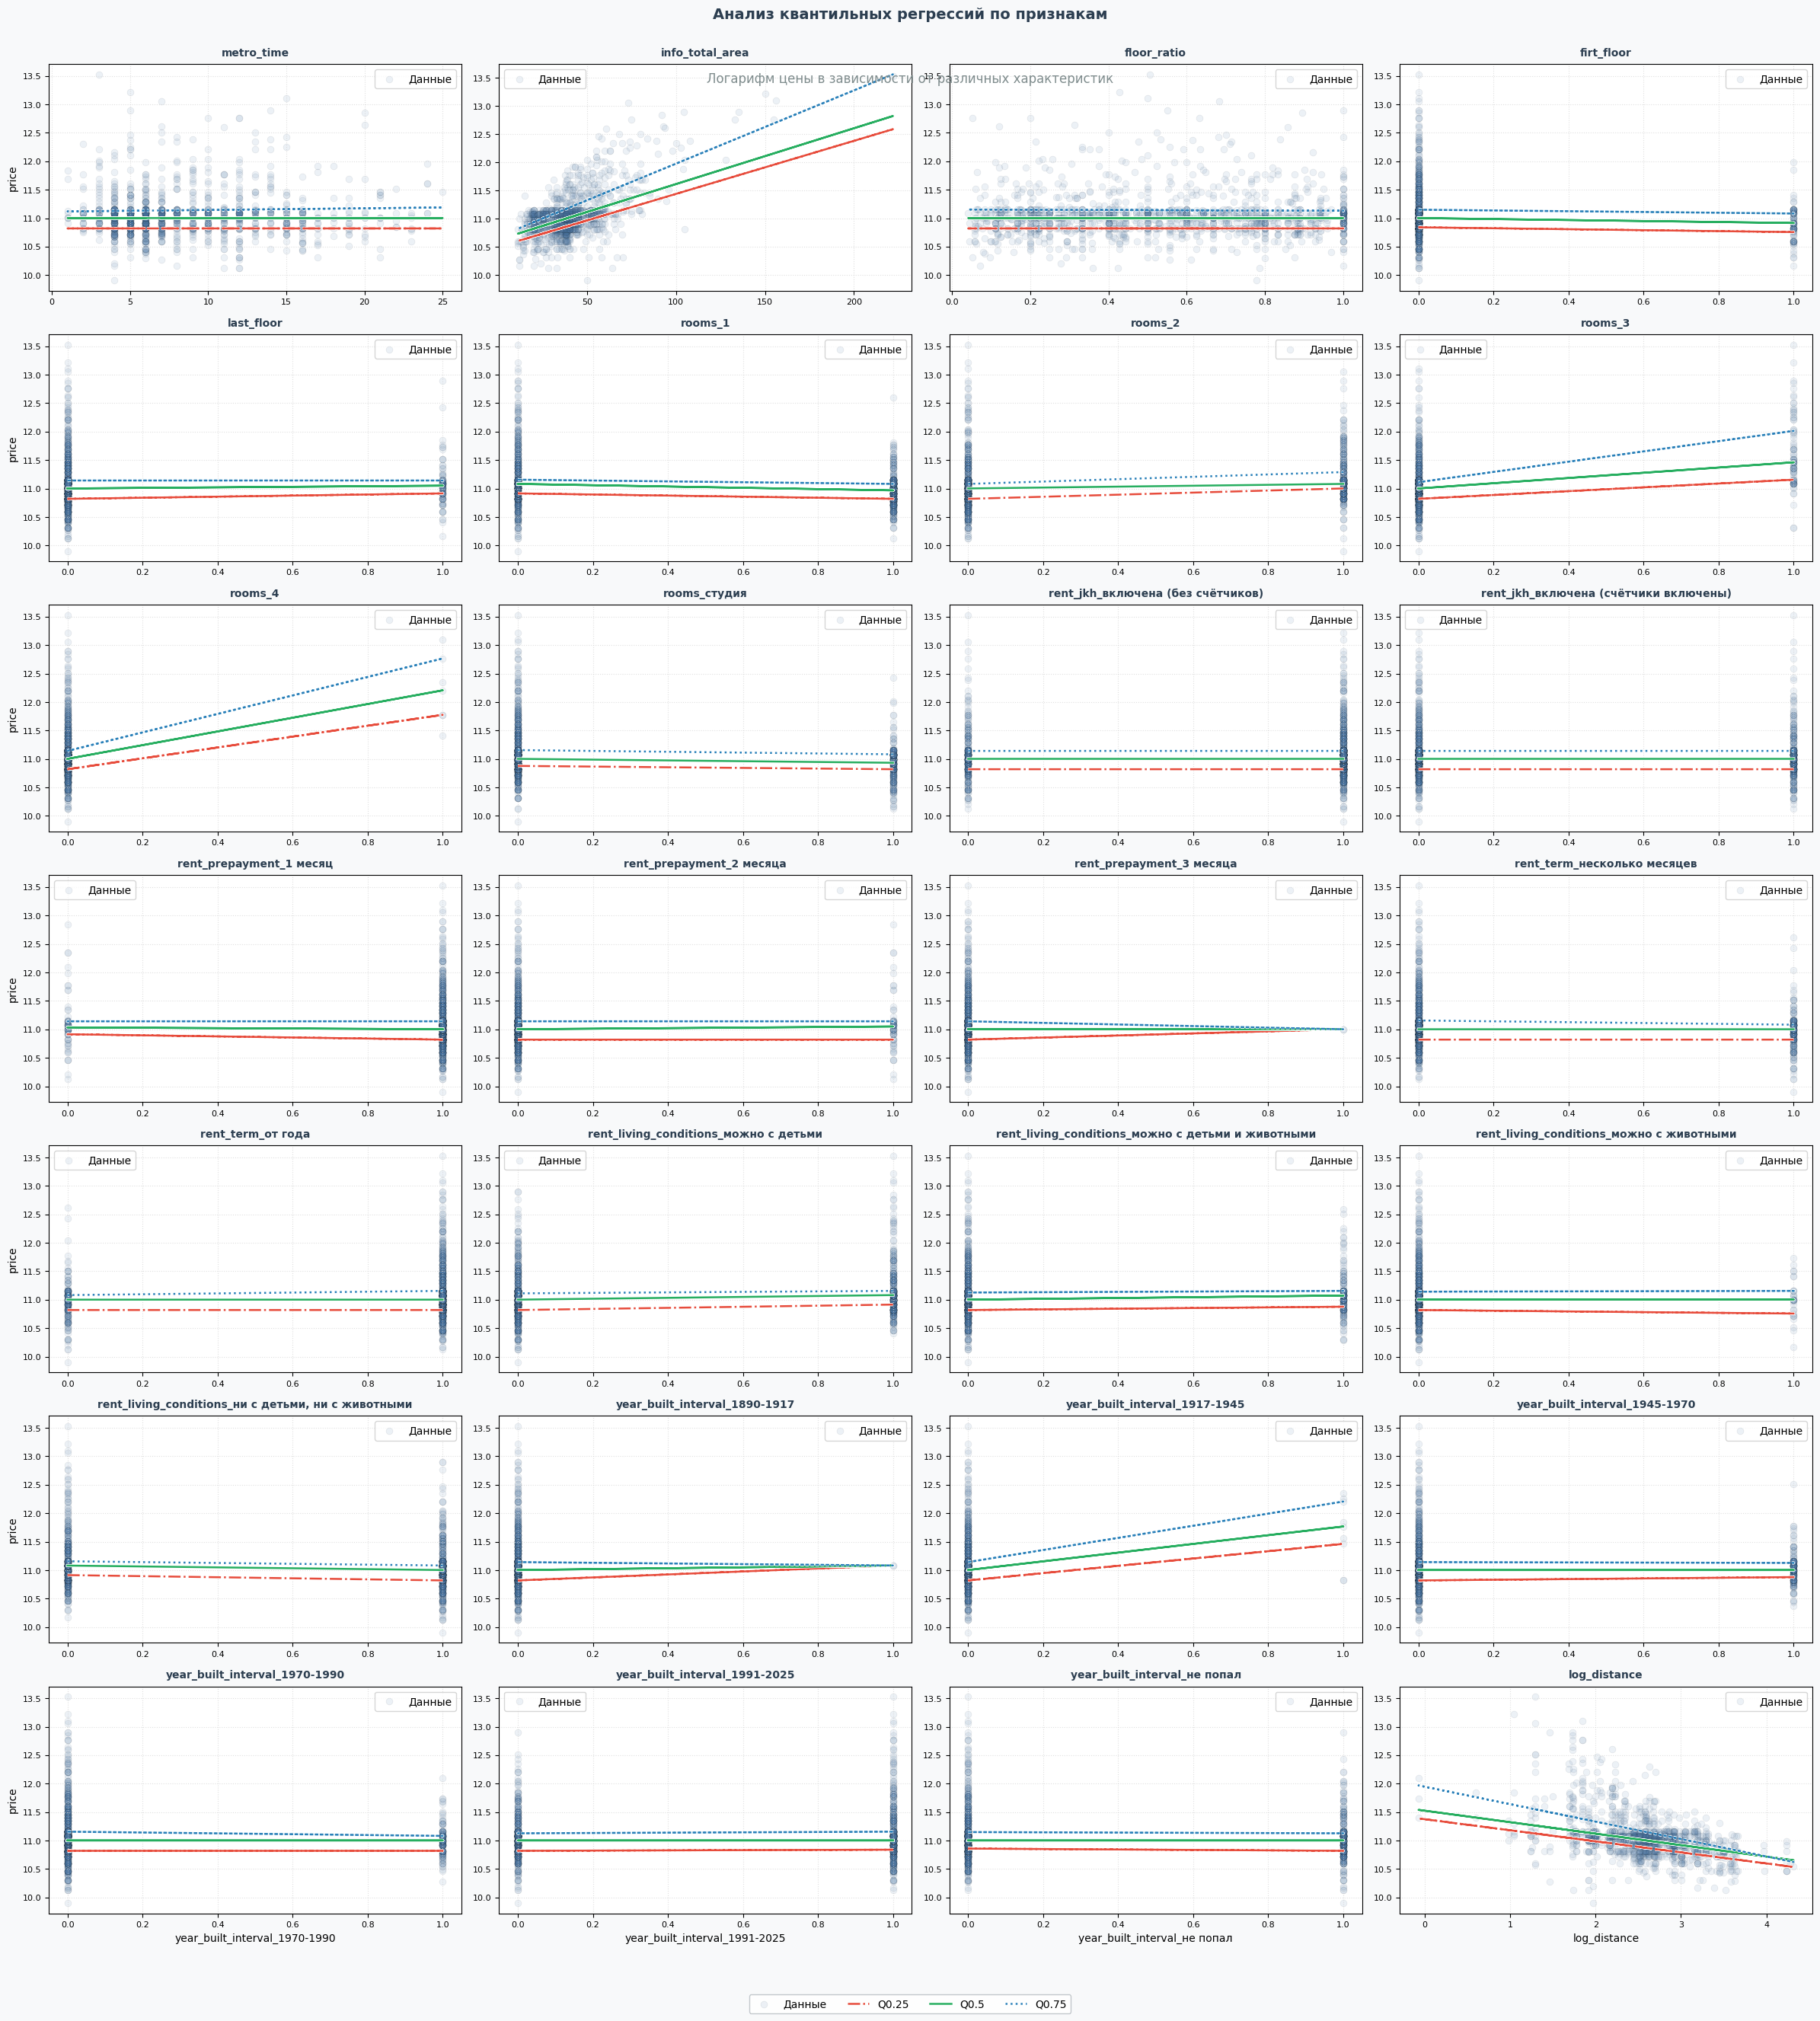

In [13]:
def plot_quantile_grid(X, y, quantiles, colors, figsize=(28, 35)):
    """Функция для построения сетки графиков квантильной регрессии"""
    features = X.columns
    n_rows, n_cols = 7, 4
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    fig.subplots_adjust(hspace=0.4, wspace=0.3)
    fig.patch.set_facecolor('#f8f9fa')

    for idx, (feature, ax) in enumerate(zip(features, axes.flatten())):
        if idx >= len(features):
            ax.axis('off')
            continue

        ax.set_facecolor('#ffffff')
        ax.grid(True, linestyle=':', color='lightgrey', alpha=0.7)

        X_feature = X[[feature]]
        X_const = sm.add_constant(X_feature)

        sns.scatterplot(x=X_feature[feature], y=y,
                        color='#4e79a7',
                        edgecolor='#2d3f4f',
                        alpha=0.1,
                        s=40,
                        ax=ax,
                        label='Данные')

        line_styles = ['-.', '-', ':']
        for q, color, ls in zip(quantiles, colors, line_styles):
            model = sm.QuantReg(y, X_const)
            result = model.fit(q=q, max_iter=100000)
            pred = result.predict(X_const)

            ax.plot(X_feature[feature], pred,
                     color=color,
                     linestyle=ls,
                     linewidth=1.8,
                     path_effects=[pe.Stroke(linewidth=3, foreground='white'), pe.Normal()],
                     label=f'Q{q}')

        ax.set_title(feature, fontsize=10, pad=8, color='#2c3e50', fontweight='bold')
        ax.tick_params(axis='both', which='major', labelsize=8)

        if idx % n_cols != 0:
            ax.set_ylabel('')
        if idx < (n_rows-1)*n_cols:
            ax.set_xlabel('')

    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels,
               loc='lower center',
               ncol=4,
               bbox_to_anchor=(0.5, 0.02),
               frameon=True,
               framealpha=0.9,
               facecolor='white',
               edgecolor='#bdc3c7',
               fontsize=10)

    fig.text(0.5, 0.96, 'Анализ квантильных регрессий по признакам',
             ha='center', va='center', fontsize=14, color='#2c3e50', fontweight='bold')
    fig.text(0.5, 0.93, 'Логарифм цены в зависимости от различных характеристик',
             ha='center', va='center', fontsize=12, color='#7f8c8d')

    plt.tight_layout(rect=[0, 0.05, 1, 0.95])
    plt.show()

specific_quantiles = [0.25, 0.5, 0.75]
palette = ['#e74c3c', '#27ae60', '#2980b9']

plot_quantile_grid(X=X_train,
                   y=y_log,
                   quantiles=specific_quantiles,
                   colors=palette,
                   figsize=(24, 28))

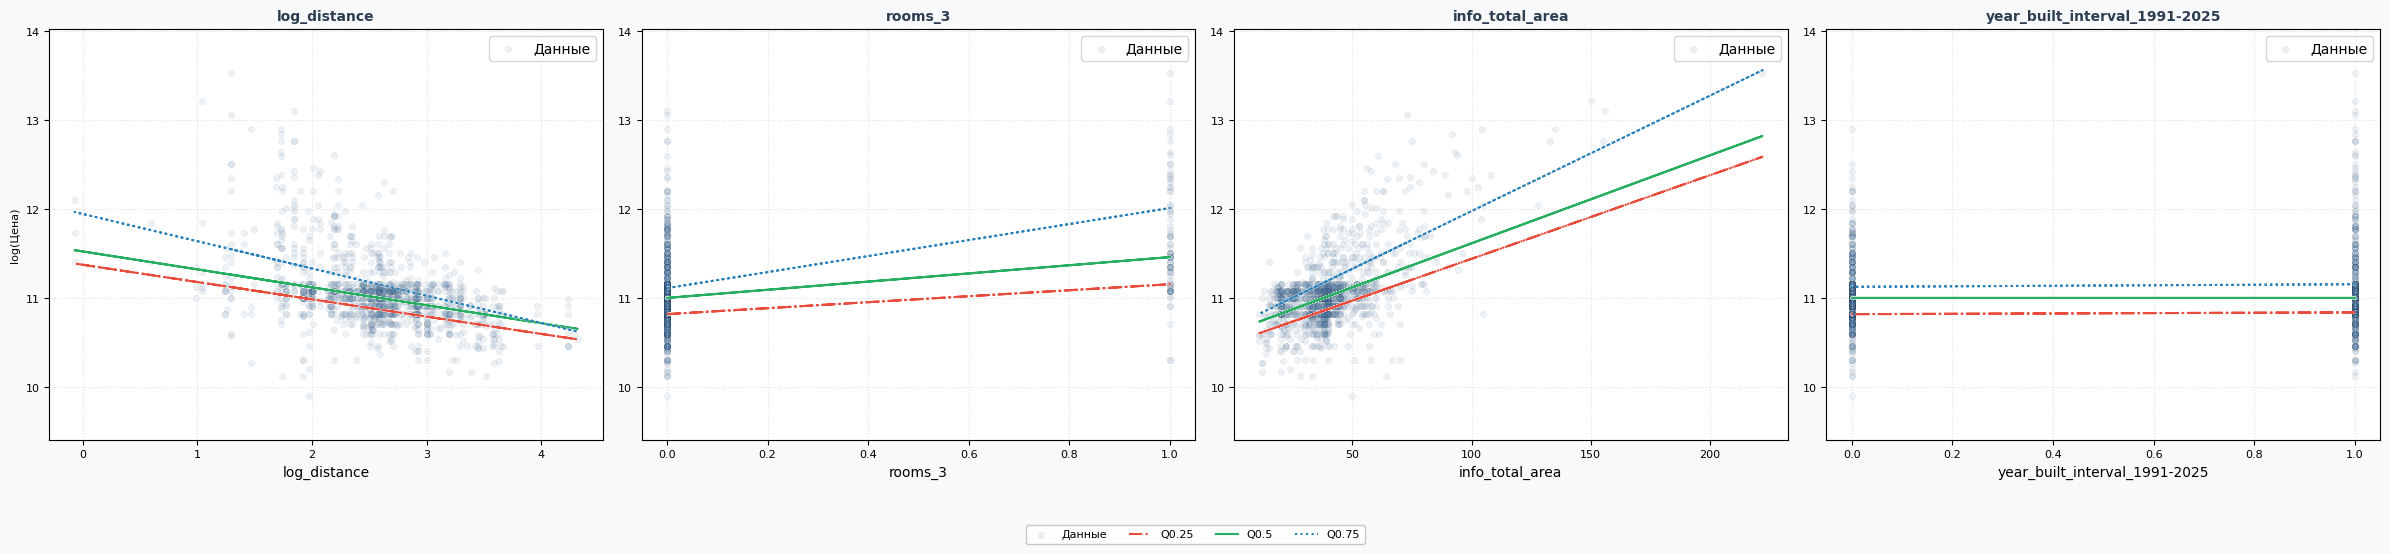

In [16]:
def plot_quantile_grid(X, y, quantiles, colors, figsize=(24, 6)):
    """Функция для построения сетки графиков с компактным вертикальным расположением"""
    features = ['log_distance', 'rooms_3', 'info_total_area', 'year_built_interval_1991-2025']
    n_rows, n_cols = 1, 4
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    fig.subplots_adjust(hspace=0.4, wspace=0.3)
    fig.patch.set_facecolor('#f8f9fa')

    y_padding = 0.5
    y_min = y.min() - y_padding
    y_max = y.max() + y_padding

    for idx, (feature, ax) in enumerate(zip(features, axes.flatten())):
        if idx >= len(features):
            ax.axis('off')
            continue

        ax.set_facecolor('#ffffff')
        ax.grid(True, linestyle=':', color='lightgrey', alpha=0.7)
        ax.set_ylim(y_min, y_max)

        X_feature = X[[feature]]
        X_const = sm.add_constant(X_feature)

        sns.scatterplot(x=X_feature[feature], y=y,
                        color='#4e79a7',
                        edgecolor='#2d3f4f',
                        alpha=0.1,
                        s=20,
                        ax=ax,
                        label='Данные')

        line_styles = ['-.', '-', ':']
        for q, color, ls in zip(quantiles, colors, line_styles):
            model = sm.QuantReg(y, X_const)
            result = model.fit(q=q, max_iter=100000)
            pred = result.predict(X_const)

            ax.plot(X_feature[feature], pred,
                     color=color,
                     linestyle=ls,
                     linewidth=1.5,
                     path_effects=[pe.Stroke(linewidth=2, foreground='white'), pe.Normal()],
                     label=f'Q{q}')

        ax.set_title(feature, fontsize=10, pad=6, color='#2c3e50', fontweight='bold')
        ax.tick_params(axis='both', which='major', labelsize=8)
        ax.set_ylabel('log(Цена)', fontsize=8) if idx == 0 else ax.set_ylabel('')

    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels,
               loc='upper center',
               ncol=5,
               bbox_to_anchor=(0.5, -0.05),
               frameon=True,
               framealpha=0.9,
               facecolor='white',
               edgecolor='#bdc3c7',
               fontsize=8)

    plt.tight_layout()
    plt.show()

plot_quantile_grid(X=X_train,
                   y=y_log,
                   quantiles=specific_quantiles,
                   colors=palette,
                   figsize=(24, 5))

In [32]:
df = pd.read_csv('FINAL_data.csv')

In [33]:
df = df.drop(columns=['rooms_студия'])
df = df.drop(columns=['rent_jkh_включена (без счётчиков)'])
df = df.drop(columns=['rent_prepayment_1 месяц'])
df = df.drop(columns=['rent_term_несколько месяцев'])
df = df.drop(columns=['rent_living_conditions_ни с детьми, ни с животными'])
df = df.drop(columns=['year_built_interval_не попал'])

In [34]:
y = np.log(df['price'])
X = df.drop("price", axis=1)

In [35]:
X_with_const = add_constant(X)

ols_model = sm.OLS(y, X_with_const).fit()

weights = 1 / (ols_model.resid ** 2 + 1e-6)

wls_model = sm.WLS(y, X_with_const, weights=weights).fit()

In [37]:
print(wls_model.summary())

                            WLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.986
Model:                            WLS   Adj. R-squared:                  0.986
Method:                 Least Squares   F-statistic:                     4180.
Date:                Tue, 22 Apr 2025   Prob (F-statistic):               0.00
Time:                        16:50:27   Log-Likelihood:                 1066.2
No. Observations:                1326   AIC:                            -2086.
Df Residuals:                    1303   BIC:                            -1967.
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
                                                        coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------

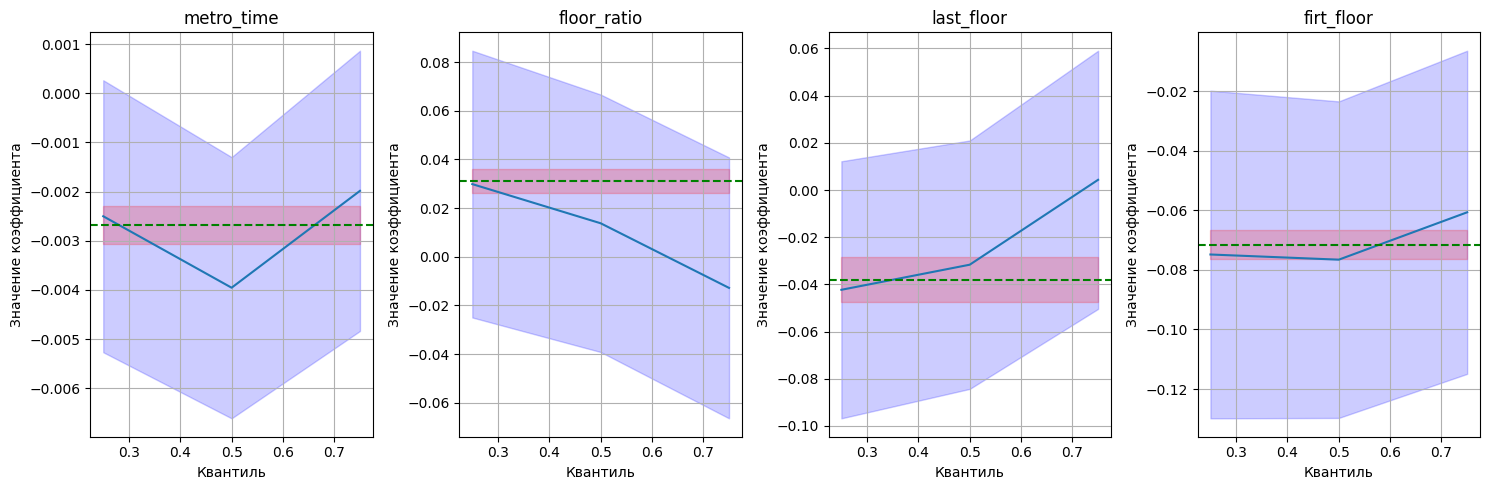

In [42]:
selected_features = ['metro_time', 'floor_ratio', 'last_floor', 'firt_floor']

# Извлечение коэффициентов и доверительных интервалов из WLS модели
wls_coefficients = wls_model.params
wls_conf_int = wls_model.conf_int()

wls_coefficients_matrix = pd.DataFrame({
    'coef': wls_coefficients,
    'lower': wls_conf_int[0],
    'upper': wls_conf_int[1]
})

# Модификация plot_data, добавив доверительный интервал для коэффициентов WLS
plot_data = []

for feature in selected_features:
    for quantile in analysis_quantiles:
        quantile_index = analysis_quantiles.index(quantile)
        plot_data.append({
            'quantile': quantile,
            'feature': feature,
            'coefficient': coefficients_matrix.loc[feature, quantile],
            'lower': confidence_intervals[feature][quantile_index][1],
            'upper': confidence_intervals[feature][quantile_index][2],
            'wls_coefficient': wls_coefficients_matrix.loc[feature, 'coef'],
            'wls_lower': wls_coefficients_matrix.loc[feature, 'lower'],
            'wls_upper': wls_coefficients_matrix.loc[feature, 'upper']
        })

plot_df = pd.DataFrame(plot_data)

n_features = len(selected_features)
n_rows = 1
n_cols = 4

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))

axes = axes.flatten()

for idx, feature in enumerate(selected_features):
    ax = axes[idx]

    feature_data = plot_df[plot_df['feature'] == feature]

    # График коэффициентов по квантилям
    sns.lineplot(data=feature_data, x='quantile', y='coefficient', hue='feature', markers=True, dashes=False, ax=ax, legend=False)

    # Заполнение доверительного интервала для квантильной регрессии
    ax.fill_between(feature_data['quantile'], feature_data['lower'], feature_data['upper'], color='blue', alpha=0.2)

    # Добавление линии с коэффициентом из модели WLS
    wls_coefficient_value = wls_coefficients_matrix.loc[feature, 'coef']
    ax.axhline(wls_coefficient_value, color='green', linestyle='--', label='Коэффициент WLS')

    # Добавление нового красного доверительного интервала для коэффициента из модели WLS
    ax.fill_between(feature_data['quantile'], feature_data['wls_lower'], feature_data['wls_upper'], color='red', alpha=0.2)

    ax.set_title(f'{feature}')
    ax.set_xlabel('Квантиль')
    ax.set_ylabel('Значение коэффициента')
    ax.grid(True)

plt.tight_layout()
plt.show()